In [131]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_context("notebook")
from scipy.stats import norm
from bokeh.plotting import figure, show
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

DATA_DIR = 'data'

In [2]:
country_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_view.csv')).dropna()  # 3 rows have no mention_country
country_inner_view = pd.read_csv(os.path.join(DATA_DIR, 'country_inner_view.csv'))
country_outer_view = pd.read_csv(os.path.join(DATA_DIR, 'country_outer_view.csv'))
country_to_type_view = pd.read_csv(os.path.join(DATA_DIR, 'country_to_country_type_view.csv'))
media_to_country_view = pd.read_csv(os.path.join(DATA_DIR, 'media_to_country_view.csv.zip'))

#### scatterplot inner-outer view by type

In [11]:
country_to_type_view[country_to_type_view.actor_country == "United States"].groupby("actor_type").count_mentions.sum().sort_values()

actor_type
INS           2
SEP         355
SET         613
RAD         731
IGO        1245
ENV        6762
REF       11372
SPY       28545
REB       38953
UAF       41793
CRM       63709
HRI       64100
LAB       70858
AGR       81086
OPP      108086
HLH      215058
NGO      271446
MIL      428533
BUS      502326
ELI      756253
CVL      866202
LEG     1163683
EDU     1453881
COP     2021742
JUD     2131908
MNC     2659906
MED     5964871
GOV    12266522
Name: count_mentions, dtype: int64

In [78]:
selected_type = "GOV"
c_to_t_selected_type = country_to_type_view[country_to_type_view.actor_type == selected_type]
select_out = c_to_t_selected_type.apply(lambda x: x.actor_country != x.mention_country, axis=1)
outer_view_type = c_to_t_selected_type[select_out].copy()
outer_view_type["sum_mentions"] = outer_view_type.groupby("actor_country").count_mentions.transform("sum")
outer_view_type = outer_view_type.groupby("actor_country").apply(lambda x: x.avg_tone * x.count_mentions \
                                        / x.sum_mentions).groupby("actor_country").sum()

inner_view_type = c_to_t_selected_type[np.logical_not(select_out)]

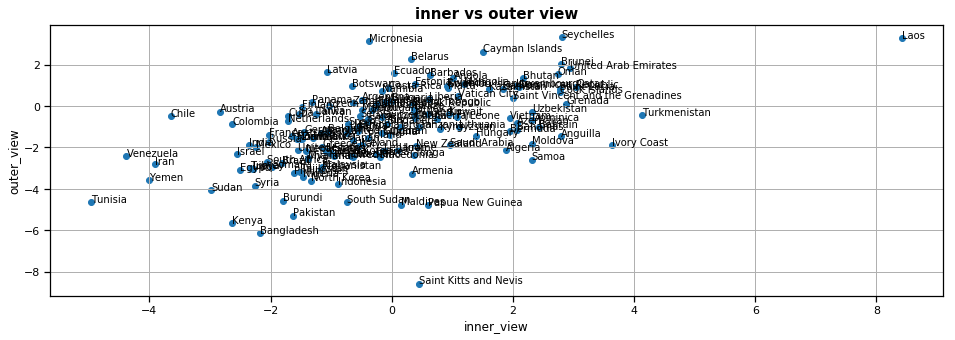

In [84]:
inner_view_type_rel = inner_view_type[inner_view_type["count_events"] > 1000]
outer_view_type_rel = pd.DataFrame(outer_view_type, columns=["avg_tone"])
inner_outer_view = inner_view_type_rel[["actor_country", "avg_tone"]].merge(outer_view_type_rel, left_on="actor_country", 
                                            right_index=True, suffixes=("_in", "_out"))
inner_outer_view.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(16,5))
ax.scatter(x='avg_tone_in', y='avg_tone_out', data=inner_outer_view)
ax.set_title("inner vs outer view", fontsize=15, fontweight='bold')
ax.set_ylabel('outer_view')
ax.set_xlabel('inner_view')
ax.grid(True)

for i, txt in enumerate(inner_outer_view.actor_country):
    ax.annotate(txt, (inner_outer_view.avg_tone_in[i], inner_outer_view.avg_tone_out[i]))

#### clustering withtout using actor_types

In [165]:
# taking the biggest countries in term of references
big_countries = list(country_outer_view.sort_values(by="count_mentions", 
                                                    ascending=False).head(40).country)
to_cluster = country_to_country_view[["actor_country", "mention_country", "avg_tone"]]
to_cluster = to_cluster[to_cluster.apply(lambda x: x.actor_country in big_countries 
                                         and x.mention_country in big_countries, axis = 1)]
mean_opinion = to_cluster.avg_tone.mean()
countries = np.intersect1d(to_cluster.actor_country.unique(), to_cluster.mention_country.unique())
to_cluster = to_cluster.set_index(["actor_country", "mention_country"])  # so that access is fast

In [166]:
opinions = mean_opinion*np.ones((countries.shape[0], countries.shape[0]))  # we put the mean
# value when countryA has no opinion on country B
for i in range(opinions.shape[0]):
    for j in range(opinions.shape[0]):
        try:
            opinions[i,j] = to_cluster.loc[countries[i], countries[j]]
        except KeyError as e:
            pass  # in this case we leave the default value in the array since there is no mention

In [130]:
best_nbr_clusters, max_sil_score = -1, -1
clusters = [None] * 8
for nbr_clusters in range(2,8):
    clusters[nbr_clusters] = KMeans(n_clusters=nbr_clusters).fit_predict(opinions)
    sil_score = silhouette_score(opinions, clusters[nbr_clusters])
    print(f"{nbr_clusters}: {sil_score}")
    if sil_score > max_sil_score:
        max_sil_score = sil_score
        best_nbr_clusters = nbr_clusters

for i in range(best_nbr_clusters):
    print(countries[clusters[best_nbr_clusters] == i])

2: 0.12271946752033995
3: 0.06281960606526311
4: 0.03406485477206747
5: 0.015355810792291997
6: 0.0329197302849288
7: 0.020932718898084013
['Anguilla' 'Antigua and Barbuda' 'Argentina' 'Aruba' 'Australia'
 'Austria' 'Bahamas' 'Barbados' 'Belarus' 'Belize' 'Benin' 'Bermuda'
 'Bhutan' 'Bolivia' 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Canada'
 'Cape Verde' 'Cayman Islands' 'Chile' 'China' 'Colombia' 'Cook Islands'
 'Costa Rica' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark'
 'Dominican Republic' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Grenada' 'Guinea' 'Guyana'
 'Hong Kong' 'Iceland' 'India' 'Ireland' 'Italy' 'Jamaica' 'Japan'
 'Kazakhstan' 'Kuwait' 'Laos' 'Latvia' 'Lesotho' 'Liberia' 'Lithuania'
 'Luxembourg' 'Macau' 'Madagascar' 'Malta' 'Mauritius' 'Micronesia'
 'Moldova' 'Mongolia' 'Morocco' 'Mozambique' 'Namibia' 'Netherlands'
 'New Zealand' 'Nicaragua' 'Norway' 'Oman' 'Panama' 'Paraguay' 'Peru'
 'Poland' 'Portugal' 'Puerto Rico' 'Qat

In [175]:
clusters = DBSCAN(eps=6).fit_predict(opinions)
for i in range(np.max(clusters)+1):
    print(countries[clusters == i])

['Australia' 'Egypt' 'France' 'Germany' 'Greece' 'Iran' 'Ireland' 'Israel'
 'Italy' 'Jordan' 'Lebanon' 'Mexico' 'Netherlands' 'North Korea' 'Poland'
 'Russia' 'Saudi Arabia' 'South Korea' 'Spain' 'Switzerland'
 'United Kingdom']


In [177]:
print(opinions)

[[-3.89880085 -4.20903736 -1.43405564 ... -5.0178733  -2.68798845
  -4.21520272]
 [-2.1337765  -1.83680224 -1.207234   ... -0.26403865 -2.68798845
  -2.33632449]
 [-1.63143334 -4.52930297 -1.98723265 ... -1.16812637 -2.68798845
  -0.55802633]
 ...
 [-3.35033683 -2.02539066  0.758086   ...  0.96917351 -2.68798845
  -6.52654867]
 [-3.55568928 -4.20732034 -1.27856601 ... -2.19158912  3.07917889
  -2.60151807]
 [-4.76049624 -4.78879701 -3.86508315 ... -4.64156041 -2.68798845
  -3.60884417]]
